# PAPER PEEK📜👀

The purpose of the project is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

Reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Confirm access to a GPU 

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce MX330 (UUID: GPU-77eebd61-350b-2f9c-b351-0acab8f44c51)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct 

In [2]:
# I have used the zip file but you can run below command which will clone the github repository and import the dataset.
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# !ls pubmed-rct

#OUTPUT:
# Cloning into 'pubmed-rct'...
# remote: Enumerating objects: 33, done.
# remote: Counting objects: 100% (8/8), done.
# remote: Compressing objects: 100% (3/3), done.
# remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
# Unpacking objects: 100% (33/33), 177.08 MiB | 14.49 MiB/s, done.
# PubMed_200k_RCT
# PubMed_200k_RCT_numbers_replaced_with_at_sign
# PubMed_20k_RCT
# PubMed_20k_RCT_numbers_replaced_with_at_sign
# README.md

In [3]:
# Check what files are in the PubMed_20K dataset
# !ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

#OUTPUT:
# dev.txt  test.txt  train.txt

In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Writing a function to read in all of the lines of a target text file and Visualize it.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Reading the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Data would be represented as below (Converting data into dictionary):

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
%%time
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: total: 2.25 s
Wall time: 4.26 s


In [11]:
# Check the first abstract of our training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Data is in the format of a list of dictionaries, So we turn it into a DataFrame to visualize it.

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

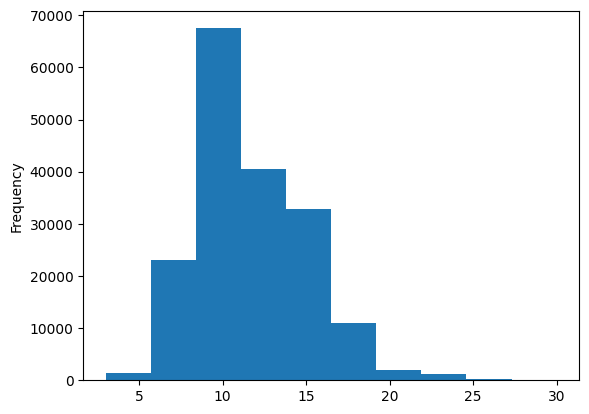

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist(); 

### Get lists of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [17]:
val_sentences[:10]

['ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'it is not clear whether these patients would benefit from antifungal treatment .',
 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
 'primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .',
 'sixty-five patients were randomized .',
 'fifty-nine patients started treatment ( @ receiving voriconazole and @ receiving plac

In [18]:
test_sentences[:10]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .",
 'when mean hemodynamic profiles were compared in patients with abnormal versus 

## Make numeric labels (ML models require numeric labels)

### LABEL ENCODE LABELS:

In [19]:
# LABEL ENCODE LABELS: Required by Baseline Model
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

### ONE HOT ENCODE LABELS:

In [20]:
# ONE HOT ENCODE LABELS: Required by CategoricalCrossEntropy Loss function
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Series of modelling experiments

Building different models and seeing which one works best.

We will initially begin with a baseline model (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Building a baseline model (Naive Bayes with TF-IDF encoder)

* A baseline model is an important first step in any series of modelling experiments.

* It sets the pace for the subsequent experiments.

* It should start with a simple model and later models (with increasing complexity) will try to beat it.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

We had wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here we will just import it.

In [25]:
from helper_functions import calculate_results

In [26]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing data (the text) for deep sequence models

Before we start building deeper models, we've to create vectorization and embedding layers.

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [29]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

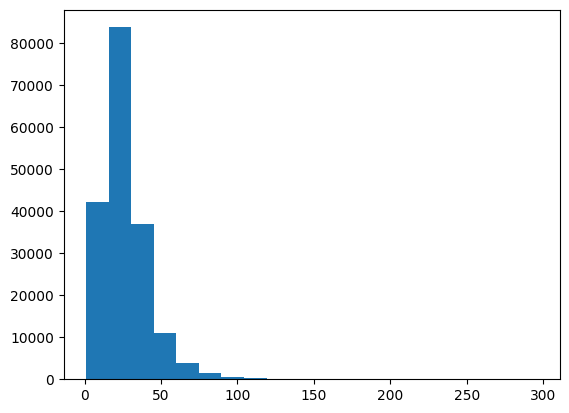

In [30]:
# How does the distribution look?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [31]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

Make a layer which maps our tokens(texts) from words to numbers.

In [33]:
# How many words are in our vocab? i.e. size of vocabulary 
# SOURCE: (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [34]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
we projected feasible reductions in tb incidence and mortality in the general population and among plhiv specifically at the end of @ years after implementing an ipt program .

Length of text: 29

Vectorized text: [[   43  9877  1099   626     5  2436   214     3   259     5     2   351
    278     3   116 22136  1850    15     2   199     4    64    21  3263
     26  4703   256     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically differnt numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 we projected feasible reductions in tb incidence and mortality in the general population and among plhiv specifically at the end of @ years after implementing an ipt program .

Sentence after vectorization (before embedding):
 [[   43  9877  1099   626     5  2436   214     3   259     5     2   351
    278     3   116 22136  1850    15     2   199     4    64    21  3263
     26  4703   256     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.01805509  0.04085538 -0.04613863 ...  0.00118493  0.04094953
   -0.00905318]
  [ 0.02489264  0.03495001  0.00305319 ... -0.01757627 -0.00626468
    0.00420761]
  [-0.00700867  0.00440992 -0.00031871 ...  0.03252386  0.01992958
   -0.01793767]
  ...
  [ 0.00547037 -0.00327476  0.01179194 ... -0.02815155  0.0291023
   -0.01924567]
  [ 0.00547037 -0.00327476  0.0117

## Creating datasets (To load data as fast as possible)

Setup data to run as fast as possible with the TensorFlow `tf.data API`.

**Resources:** Many of the steps here are discussed at length in these two resources
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [41]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [43]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [45]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [46]:
# NO. OF BATCHES OF TRAINING DATASET
len(train_dataset)

5627

In [47]:
# NO. OF BATCHES OF TRAINING DATASET x BATCH SIZE = TOTAL TRAINING DATA
5627*32

180064

In [48]:
# Fit the model (Training on 10% of batch every epoch)
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3


562/562 [==============================] - 160s 281ms/step - loss: 0.9210 - accuracy: 0.6356 - val_loss: 0.6845 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 143s 255ms/step - loss: 0.6555 - accuracy: 0.7590 - val_loss: 0.6308 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 144s 256ms/step - loss: 0.6147 - accuracy: 0.7758 - val_loss: 0.5950 - val_accuracy: 0.7852


In [49]:
# Evalaute on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.5958 - accuracy: 0.7874


[0.5957702398300171, 0.787402331829071]

In [50]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 19s 20ms/step


(array([[4.6097702e-01, 1.3752647e-01, 5.7644691e-02, 3.1610054e-01,
         2.7751246e-02],
        [4.1314289e-01, 3.3882919e-01, 1.2666935e-02, 2.2287488e-01,
         1.2486029e-02],
        [1.6740589e-01, 5.6855823e-03, 2.4008309e-03, 8.2447821e-01,
         2.9445820e-05],
        ...,
        [8.6765549e-06, 6.8700133e-04, 1.0829525e-03, 6.8306258e-06,
         9.9821460e-01],
        [4.5166261e-02, 4.5261934e-01, 8.1862710e-02, 6.3288316e-02,
         3.5706332e-01],
        [1.7953430e-01, 6.8866545e-01, 3.9604239e-02, 5.2708190e-02,
         3.9487883e-02]], dtype=float32),
 (30212, 5))

In [51]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [52]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74023566794651,
 'precision': 0.7841459843482087,
 'recall': 0.7874023566794651,
 'f1': 0.7847392767407068}

## Model 2: Feature extraction with pretrained token embeddings

***The paper originally used GloVe embeddings.***

However, we will be using pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4


In [53]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [54]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 the majority of patients had long-standing disease ; were older , male and white .
Sentence after embedding:
[-0.04641222  0.05291244  0.03199166  0.06344666 -0.08438665  0.0319013
  0.05883302  0.03167362 -0.0473523  -0.02395477  0.09963678  0.03936958
  0.014139    0.07592112  0.03464148  0.01824743 -0.10207924 -0.05733482
 -0.07457951 -0.07248326  0.00526465  0.04947443 -0.01523794  0.03316908
  0.03893929  0.02814494  0.06209082 -0.00913386  0.0187242   0.07579207]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [55]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here...
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [57]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [58]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3


562/562 [==============================] - 35s 37ms/step - loss: 0.9181 - accuracy: 0.6472 - val_loss: 0.7982 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 0.7688 - accuracy: 0.7016 - val_loss: 0.7556 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.7519 - accuracy: 0.7119 - val_loss: 0.7381 - val_accuracy: 0.7144


In [59]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

  5/945 [..............................] - ETA: 32s - loss: 0.8230 - accuracy: 0.6625

945/945 [==============================] - 26s 28ms/step - loss: 0.7397 - accuracy: 0.7135


[0.7397141456604004, 0.7134913206100464]

In [60]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 28s 28ms/step


array([[0.4398787 , 0.37129903, 0.00156954, 0.1794733 , 0.00777941],
       [0.32227963, 0.5301669 , 0.00259148, 0.14172454, 0.00323741],
       [0.23333113, 0.1403095 , 0.01561137, 0.575426  , 0.03532192],
       ...,
       [0.00187462, 0.0048889 , 0.04799303, 0.00117084, 0.9440726 ],
       [0.00404886, 0.05095106, 0.20947237, 0.00166163, 0.7338661 ],
       [0.19572282, 0.2750672 , 0.45809418, 0.00807271, 0.06304313]],
      dtype=float32)

In [61]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [62]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 71.34913279491593,
 'precision': 0.713568824981841,
 'recall': 0.7134913279491593,
 'f1': 0.7103639464735759}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states that it has been build using a combination of token and character-level embeddings.

We've done token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings. 

### Creating a character-level tokenizer

In [63]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [64]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e   m a j o r i t y   o f   p a t i e n t s   h a d   l o n g - s t a n d i n g   d i s e a s e   ;   w e r e   o l d e r   ,   m a l e   a n d   w h i t e   .'

In [65]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [66]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [67]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

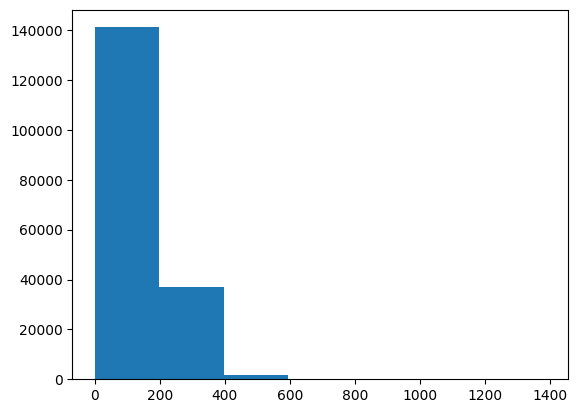

In [68]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [69]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [70]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [71]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocabulary, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None", which will then consider punctuations too.
                                    name="char_vectorizer")

In [72]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [73]:
# Check character vocabulary stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [74]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Characterized text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Characterized text:
 n i t r o g l y c e r i n   (   a r m   a   ,   n   =   @   )   o r   p l a c e b o   p a t c h e s   (   a r m   b   ,   n   =   @   )   w e r e   a d m i n i s t e r e d   o n c e   d a i l y   f r o m   d a y   - @   t o   d a y   @   o f   e a c h   c y c l e   a n d   w e r e   r e m o v e d   a b o u t   @ h   a f t e r   a d m i n i s t r a t i o n   .

Length of random_train_chars: 141

Vectorized chars:
 [[ 6  4  3  8  7 18 12 19 11  2  8  4  6  5  8 15  5  6  7  8 14 12  5 11
   2 22  7 14  5  3 11 13  2  9  5  8 15 22  6 20  2  8  2  5 10 15  4  6
   4  9  3  2  8  2 10  7  6 11  2 10  5  4 12 19 17  8  7 15 10  5 19  3
   7 10  5 19  7 17  2  5 11 13 11 19 11 12  2  5  6 10 20  2  8  2  8  2
  15  7 21  2 10  5 22  7 16  3 13  5 17  3  2  8  5 10 15  4  6  4  9  3
   8  5  3  4  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Creating a character-level embedding

In [75]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # Size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [76]:
# Test our character embedding layer
print(f"Characterized text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Characterized text:
 n i t r o g l y c e r i n   (   a r m   a   ,   n   =   @   )   o r   p l a c e b o   p a t c h e s   (   a r m   b   ,   n   =   @   )   w e r e   a d m i n i s t e r e d   o n c e   d a i l y   f r o m   d a y   - @   t o   d a y   @   o f   e a c h   c y c l e   a n d   w e r e   r e m o v e d   a b o u t   @ h   a f t e r   a d m i n i s t r a t i o n   .

Embedded chars (after vectorization and embedding):
 [[[-0.00192921  0.04983452 -0.03335271 ...  0.00291107  0.00177381
    0.00019157]
  [ 0.02936722  0.0289104  -0.03012349 ... -0.048692   -0.00263015
    0.036999  ]
  [-0.00384073 -0.03506893 -0.04689621 ... -0.04432083  0.03063968
    0.00661234]
  ...
  [-0.04842533  0.01026727 -0.04399216 ... -0.00670341 -0.02752235
    0.03544762]
  [-0.04842533  0.01026727 -0.04399216 ... -0.00670341 -0.02752235
    0.03544762]
  [-0.04842533  0.01026727 -0.04399216 ... -0.00670341 -0.02752235
    0.03544762]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings
**NOTE:** The research paper has used Bi-LSTM model while we will be using Conv1D model

In [77]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [78]:
# Summary of model_3
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [79]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [80]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [81]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 42ms/step - loss: 1.2989 - accuracy: 0.4738 - val_loss: 1.0924 - val_accuracy: 0.5658
Epoch 2/3
562/562 [==============================] - 26s 47ms/step - loss: 1.0354 - accuracy: 0.5876 - val_loss: 0.9631 - val_accuracy: 0.6273
Epoch 3/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9483 - accuracy: 0.6306 - val_loss: 0.8887 - val_accuracy: 0.6599


In [82]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 19s 19ms/step


array([[0.10846337, 0.32191765, 0.29305914, 0.18400002, 0.09255979],
       [0.14122458, 0.41675508, 0.09861554, 0.20125008, 0.1421547 ],
       [0.1315112 , 0.1860536 , 0.47080803, 0.12334735, 0.08827983],
       ...,
       [0.08418404, 0.09399771, 0.21414782, 0.10465451, 0.5030158 ],
       [0.06042651, 0.12937668, 0.34476465, 0.04952929, 0.41590282],
       [0.33991405, 0.5094571 , 0.04489843, 0.09396446, 0.01176596]],
      dtype=float32)

In [83]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 1], dtype=int64)>

In [84]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.90798358268238,
 'precision': 0.6447104203479036,
 'recall': 0.6490798358268238,
 'f1': 0.6372319435137308}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`) 
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [85]:
# 1. Setup token inputs/model (similiar to Model_1)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

In [86]:

# 2. Setup char inputs/model (similiar to Model_3 but with Bi-LSTM model)
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [87]:

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [88]:

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
# NOTE: The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [89]:

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [90]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

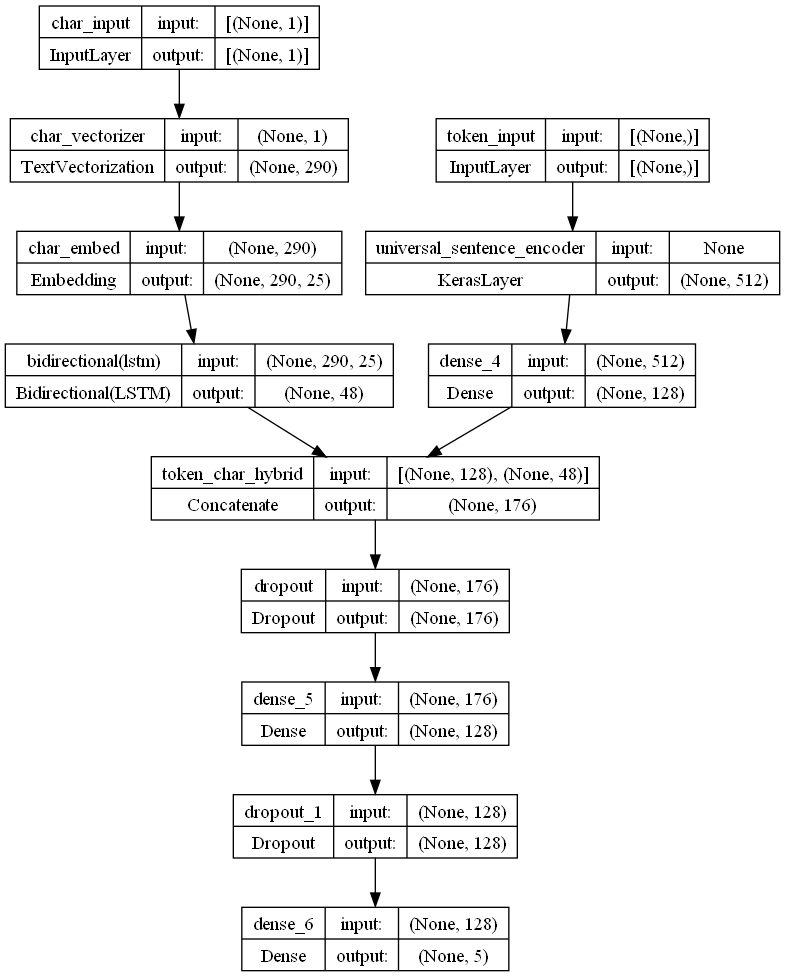

In [120]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [92]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper uses SGD for optimization
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [93]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [95]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [96]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3


562/562 [==============================] - 244s 362ms/step - loss: 0.9884 - accuracy: 0.6085 - val_loss: 0.7889 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 168s 299ms/step - loss: 0.8053 - accuracy: 0.6916 - val_loss: 0.7218 - val_accuracy: 0.7277
Epoch 3/3
562/562 [==============================] - 118s 210ms/step - loss: 0.7751 - accuracy: 0.7043 - val_loss: 0.6910 - val_accuracy: 0.7370


In [97]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 28s 30ms/step - loss: 0.6942 - accuracy: 0.7363


[0.6941604018211365, 0.7362968325614929]

In [98]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 33s 32ms/step


array([[3.9385906e-01, 4.4228050e-01, 5.7938523e-03, 1.4885210e-01,
        9.2144338e-03],
       [3.6813557e-01, 4.4470021e-01, 5.0936383e-03, 1.7900482e-01,
        3.0656757e-03],
       [2.9843700e-01, 1.7119420e-01, 7.4066445e-02, 4.0346575e-01,
        5.2836649e-02],
       ...,
       [4.1703996e-04, 5.5917082e-03, 7.2827578e-02, 2.0155024e-04,
        9.2096210e-01],
       [1.2324390e-02, 9.7220853e-02, 1.9658142e-01, 5.1058047e-03,
        6.8876749e-01],
       [2.8228682e-01, 3.0204123e-01, 2.7768183e-01, 4.8876014e-02,
        8.9114107e-02]], dtype=float32)

In [99]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [100]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.6296835694426,
 'precision': 0.7351228110505333,
 'recall': 0.736296835694426,
 'f1': 0.7323180629040671}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

**NOTE:** We will add positional embeddings using feature engineering

In [101]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **IMPORTANT NOTE:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [102]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

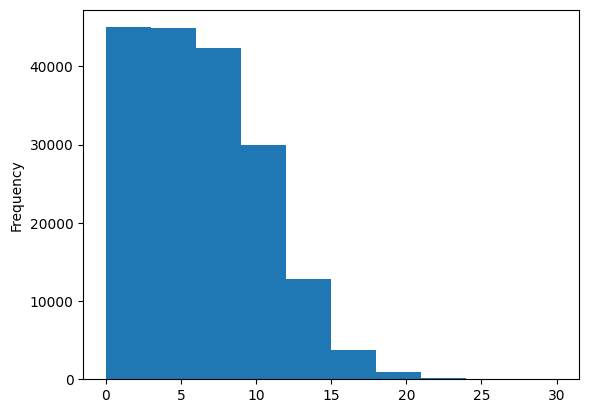

In [103]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [104]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

We've encoded our line numbers feature, Similarly, for total lines feature...

In [105]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

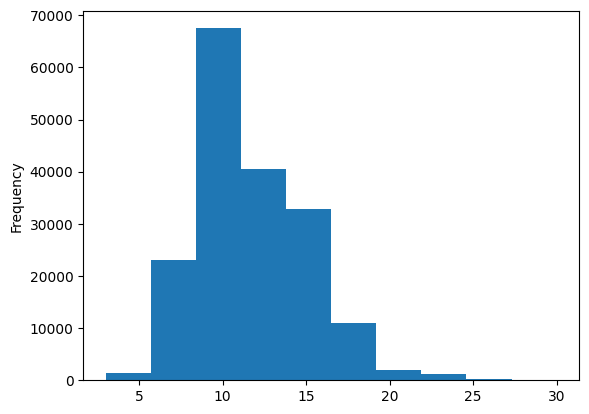

In [106]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [107]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [108]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities 
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [109]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

In [110]:
# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

In [111]:
# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_outputs)

In [112]:
# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=total_lines_outputs)

In [113]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
combined_embeddings_outputs = layers.Dropout(0.5)(z)

In [114]:
# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 combined_embeddings_outputs])

In [115]:
# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

In [116]:
# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [117]:
# Summary of tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

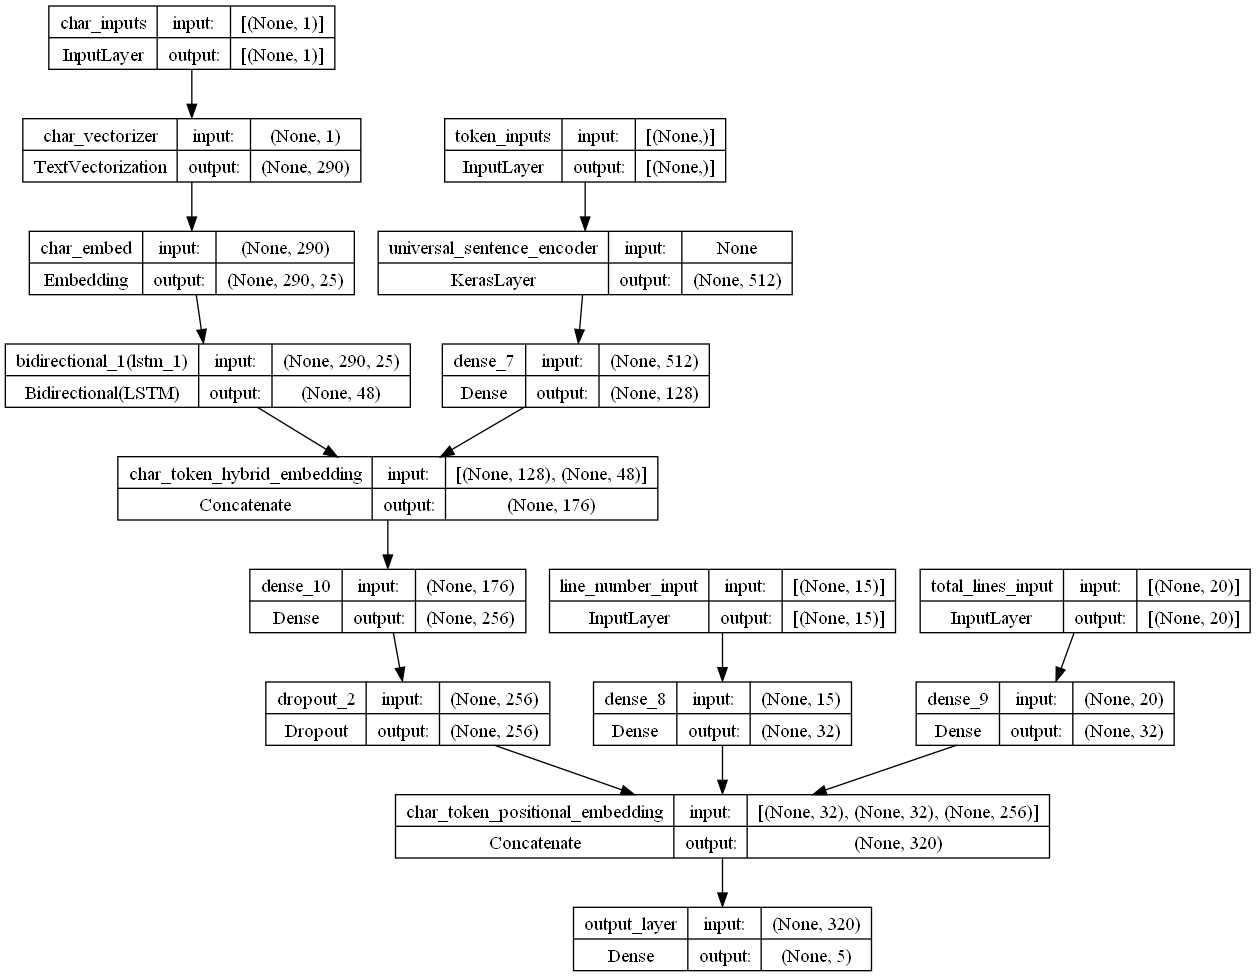

In [118]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]` 

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]` 

> **RESOURCE:** For more information on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/ 

In [119]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [121]:
# Create training and validation TensorFlow datasets (with all four different types of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [122]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predicitions with our tribrid model

In [123]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 120s 180ms/step - loss: 1.0954 - accuracy: 0.7263 - val_loss: 0.9801 - val_accuracy: 0.8115
Epoch 2/3
562/562 [==============================] - 172s 306ms/step - loss: 0.9664 - accuracy: 0.8128 - val_loss: 0.9511 - val_accuracy: 0.8191
Epoch 3/3
562/562 [==============================] - 165s 294ms/step - loss: 0.9500 - accuracy: 0.8247 - val_loss: 0.9391 - val_accuracy: 0.8314


In [124]:
# Evaluate one the whole validation dataset
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 79s 83ms/step - loss: 0.9369 - accuracy: 0.8312


[0.9368525147438049, 0.8311929106712341]

In [125]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 73s 70ms/step


array([[0.50525045, 0.11979675, 0.01636513, 0.33940354, 0.0191841 ],
       [0.5496148 , 0.0895056 , 0.06042027, 0.2901021 , 0.01035729],
       [0.29560685, 0.11489639, 0.14568748, 0.37579617, 0.06801306],
       ...,
       [0.03876924, 0.11454909, 0.03976453, 0.03628057, 0.7706365 ],
       [0.02943186, 0.32509103, 0.07706442, 0.02550894, 0.5429037 ],
       [0.15289108, 0.66214764, 0.09623531, 0.03741942, 0.05130653]],
      dtype=float32)

In [126]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [127]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.11929034820601,
 'precision': 0.8300064360312509,
 'recall': 0.8311929034820601,
 'f1': 0.8300789995917315}

## Compare all model results

In [128]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.740236,0.784146,0.787402,0.784739
model_2_pretrained_token_embedding,71.349133,0.713569,0.713491,0.710364
model_3_custom_char_embedding,64.907984,0.644710,0.649080,0.637232
model_4_hybrid_char_token_embedding,73.629684,0.735123,0.736297,0.732318
model_5_pos_char_token_embedding,83.119290,0.830006,0.831193,0.830079


In [129]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

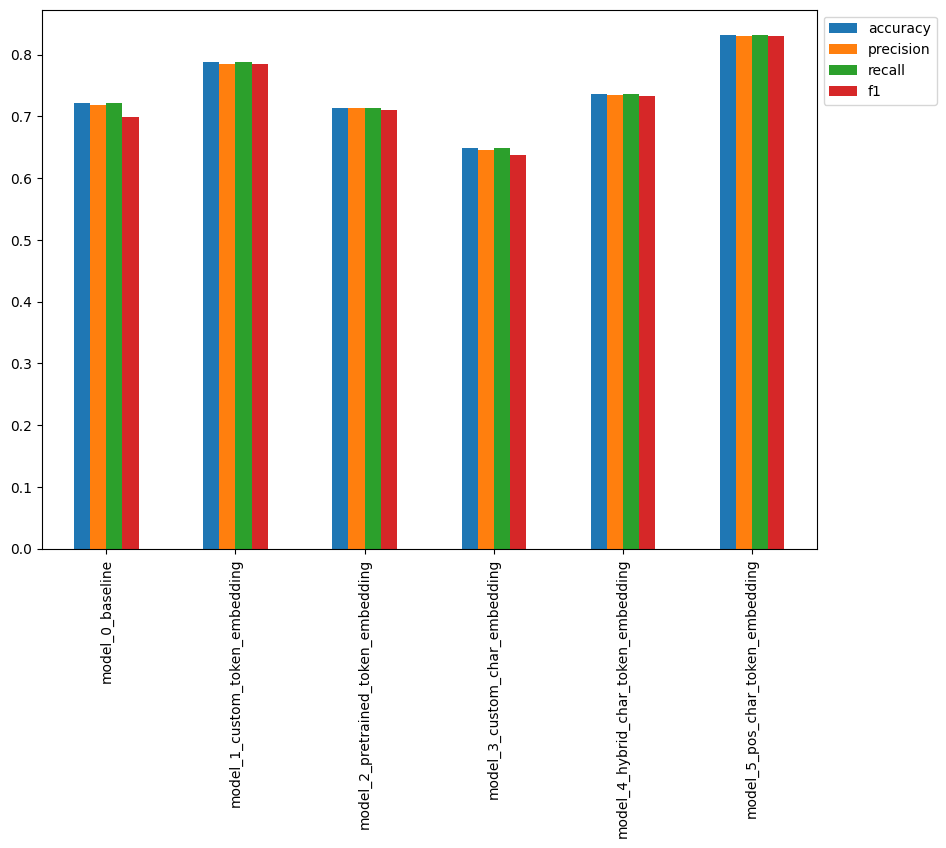

In [130]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

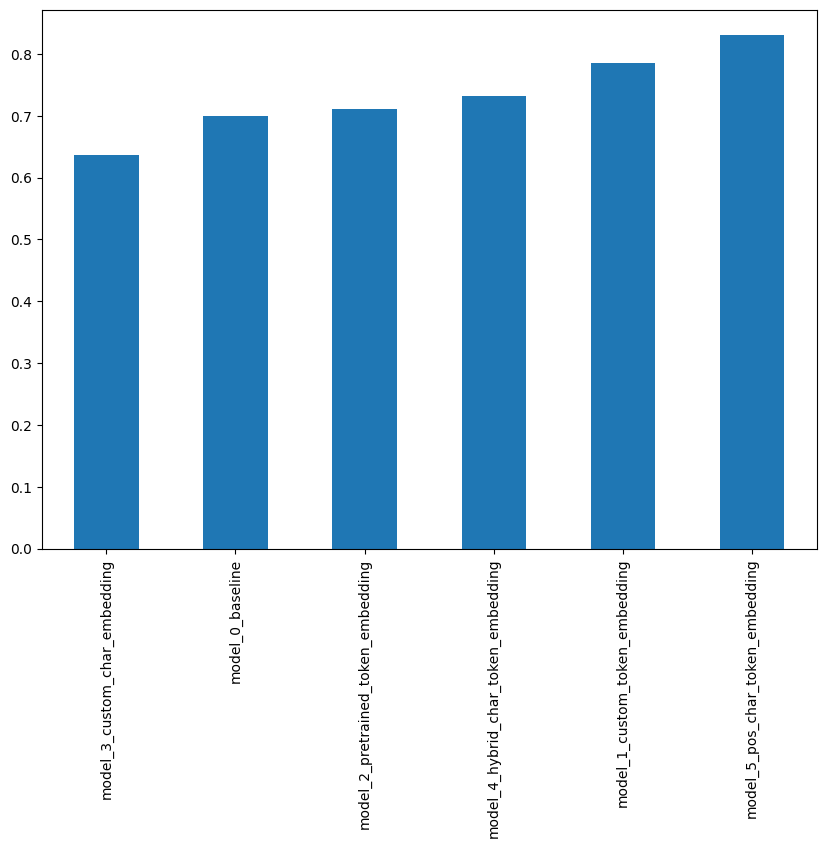

In [131]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and Load best performing model (Model_5) 

In [141]:
# Save the best performing model to SavedModel format (default)
model_5.save("paper_peek_model_5")

INFO:tensorflow:Assets written to: paper_peek_model_5\assets


INFO:tensorflow:Assets written to: paper_peek_model_5\assets


In [142]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("paper_peek_model_5")

In [143]:
# Evaluate the loaded model
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 51s 49ms/step - loss: 0.9369 - accuracy: 0.8312


[0.9368525147438049, 0.8311929106712341]

In [144]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 46s 46ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

Compare our loaded model's predictions with the prediction results we obtained before saving our model.

In [150]:
# Compare loaded model results with original trained model results
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [145]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.11929034820601,
 'precision': 0.8300064360312509,
 'recall': 0.8311929034820601,
 'f1': 0.8300789995917315}

In [155]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

## Evaluate model on test dataset

To make our model's performance more comparable with the results reported in Table 3 of the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper, Making predictions on the test dataset and evaluate them.

In [151]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [152]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 40s 42ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0], dtype=int64)>

In [154]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_label_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.67131242740999,
 'precision': 0.8251533963820284,
 'recall': 0.8267131242740999,
 'f1': 0.8255842258854734}

However, it seems our best model still has not been able to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, while our Model_5 gets ~82.67 F1-score).

But our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So we can still improve the model but changes few things which might help us improve our results.

## Find most wrong

One of the best ways to see whether the model is going wrong (or potentially where your data is wrong) is to visualize the "most wrong" predictions.

**The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagree with the ground truth label).**

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

In [156]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: total: 5.61 s
Wall time: 5.74 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 

Now we'll improve our test DataFame with a few values:
* A `"prediction"` (string) column containing our model's prediction for a given sample.
* A `"pred_prob"` (float) column containing the model's maximum prediction probabiliy for a given sample.
* A `"correct"` (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [158]:
# Create prediction-improved test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.448799,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.331142,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.748487,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.605703,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.744526,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.891503,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.571470,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.499744,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.455520,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.552207,True


In [162]:
# Find top 10 most wrong samples
top_10_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]
top_10_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.948799,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.934343,False
16633,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,19,19,BACKGROUND,0.933929,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.933726,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.930123,False
...,...,...,...,...,...,...,...
8638,METHODS,this study is registered with clinicaltrials.g...,5,9,RESULTS,0.844621,False
25345,RESULTS,participants were randomized to an hpd or an s...,3,12,METHODS,0.843534,False
23305,CONCLUSIONS,the c/s rate was higher in groups c and d ; ho...,10,11,RESULTS,0.842113,False
29007,RESULTS,control group patients received a wallet card ...,5,14,METHODS,0.842109,False


In [164]:
# Visualize top wrong predictions
for row in top_10_wrong[0:5].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9487990736961365, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9343425631523132, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9339290857315063, Line number: 19, Total lines: 19

Text:
clinicaltrials.gov identifier : nct@ .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9337255358695984, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9301228523254395, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----



There might be a possibility that the dataset might been labelled incorrectly.To improve, we could go through your training dataset, update the labels and then retrain a model. 
> **NOTE:** The process of using a model to help improve/investigate your dataset's labels is often referred to as **active learning**.